# Edge Dropout Analysis

This will look at the changes in performance of the algorithm when different edges are removed at different rates.

Ensure that the scripts `run_time_ml_pipeline.sh` and `run_all_dropouts.py` have both run to completeion before runing this noteboke.

In [1]:
import os

import pandas as pd
import numpy as np
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../../../hetnet-ml/src')
import graph_tools as gt
import plot_tools as pt

DATA_DIR = '../../data'

paper_figs = os.path.join(DATA_DIR, 'figures/paper_figs')
supp_figs = os.path.join(DATA_DIR, 'figures/supp_figs')
other_figs = os.path.join(DATA_DIR, 'figures/other_figs')

In [2]:
full_result = pd.read_csv(os.path.join(DATA_DIR, 'time_networks-6_metanode/1985/alpha_0.1/10x_pos-neg',
                                       '0_year_diff/recall-scoring/2_pmids/dwpc_w_0.6/predictions.csv'))
full_result.head(2)

,cd_id,cd_name,do_id,do_name,status,approval_year,year_diff,year_cat,dataset,test_probas,all_probas,cd_percentile,do_percentile
0,D017706,Lisinopril,C0001263,Abdominal actinomycosis,0,NaN,NaN,NaN,unused,NaN,0.027761,0.573228,0.001119
1,D016293,Moricizine,C0001263,Abdominal actinomycosis,0,NaN,NaN,NaN,unused,NaN,0.027999,0.568504,0.002237


In [3]:
base_dir = os.path.join(DATA_DIR, 'edge_dropout_testing/1985/')
rates = [0.25, 0.5, 0.75, 1.0]
seeds = [i for i in range(5)]

edges = sorted([d for d in os.listdir(base_dir)])

test_res = []

for et in tqdm(edges):
    for rate in rates:
        for seed in seeds:
            # Dropout rate of 1.0 only tested once
            if rate == 1.0 and seed != 0:
                continue
            
            result_file = os.path.join(base_dir, et, 'rate_{}'.format(rate), 'seed_{}'.format(seed), '2_pmids/predictions.csv')
            res = pd.read_csv(result_file)
            
            res['dropout_edge'] = et
            res['dropout_rate'] = rate
            res['dropout_seed'] = seed
            
            test_res.append(res.query('dataset == "test"').copy())
test_res = pd.concat(test_res)

100%|██████████| 30/30 [08:58<00:00, 17.77s/it]


In [4]:
test_res.head(2)

,cd_id,cd_name,do_id,do_name,status,approval_year,year_diff,year_cat,dataset,test_probas,all_probas,cd_percentile,do_percentile,dropout_edge,dropout_rate,dropout_seed
58,D004205,Cromolyn Sodium,C0001263,Abdominal actinomycosis,0,NaN,NaN,NaN,test,0.029619,0.029619,0.439370,0.065996,AFFECTS_CDafA,0.25,0
114,C021092,stiripentol,C0001263,Abdominal actinomycosis,0,NaN,NaN,NaN,test,0.030299,0.030299,0.524409,0.128635,AFFECTS_CDafA,0.25,0


In [5]:
from scipy import interp                                                             
from sklearn.metrics import precision_recall_curve, roc_curve, auc        

def calc_roc(df):

    fpr, tpr, thresholds = roc_curve(df['status'], df['all_probas'])                                  
    roc_auc = auc(fpr, tpr)                                                      
    return roc_auc
    
def calc_prc(df):
    pre, rec, thresholds = precision_recall_curve(df['status'], df['all_probas'])                                  
    roc_prc = auc(rec, pre)                                                      
    return roc_prc

In [6]:
full_result.head(2)

,cd_id,cd_name,do_id,do_name,status,approval_year,year_diff,year_cat,dataset,test_probas,all_probas,cd_percentile,do_percentile
0,D017706,Lisinopril,C0001263,Abdominal actinomycosis,0,NaN,NaN,NaN,unused,NaN,0.027761,0.573228,0.001119
1,D016293,Moricizine,C0001263,Abdominal actinomycosis,0,NaN,NaN,NaN,unused,NaN,0.027999,0.568504,0.002237


In [7]:
calc_roc(full_result.query('dataset == "test"'))

0.7979311685338772

In [8]:
from collections import defaultdict

In [9]:
roc_result = defaultdict(list)

orig_roc = calc_roc(full_result.query('dataset == "test"'))
orig_prc = calc_prc(full_result.query('dataset == "test"'))

for et in edges:
    roc_result['edge'].append(et)
    roc_result['seed'].append(0)
    roc_result['rate'].append(0.0)
    roc_result['auroc'].append(orig_roc)
    roc_result['auprc'].append(orig_prc)

for grp, frame in test_res.groupby(['dropout_edge', 'dropout_rate', 'dropout_seed']):
    roc = calc_roc(frame)
    prc = calc_prc(frame)
    
    roc_result['edge'].append(grp[0])
    roc_result['rate'].append(grp[1])
    roc_result['seed'].append(grp[2])
    roc_result['auroc'].append(roc)
    roc_result['auprc'].append(prc)
    
roc_result = pd.DataFrame(roc_result).sort_values(['edge', 'rate', 'seed'])

In [10]:
roc_result.head(2)

,auprc,auroc,edge,rate,seed
0,0.447420,0.797931,AFFECTS_CDafA,0.00,0
30,0.448533,0.799234,AFFECTS_CDafA,0.25,0


In [11]:
mean_result = roc_result.groupby(['edge', 'rate'])[['auprc', 'auroc']].mean().reset_index()
mean_result.head(2)

,edge,rate,auprc,auroc
0,AFFECTS_CDafA,0.00,0.447420,0.797931
1,AFFECTS_CDafA,0.25,0.447569,0.797846


In [12]:
res_std = mean_result.groupby('edge').std().sort_values('auroc', ascending=False).reset_index()
res_std

,edge,rate,auprc,auroc
0,TREATS_CDtDO,0.395285,0.074655,0.037022
1,RELATED_TO_CDrtCD,0.395285,0.026397,0.009549
2,ASSOCIATED_WITH_DOawDO,0.395285,0.009121,0.006376
3,LOCATION_OF_AloCD,0.395285,0.004217,0.003529
4,STIMULATES_CDstG,0.395285,0.001227,0.002153
5,INHIBITS_GinDO,0.395285,0.001698,0.001853
6,AUGMENTS_GagDO,0.395285,0.001897,0.001610
7,LOCATION_OF_AloG,0.395285,0.000448,0.001593
8,INHIBITS_GinCD,0.395285,0.001669,0.001528
9,AFFECTS_CDafA,0.395285,0.001852,0.001500


In [13]:
def get_range(s):
    """Gets the difference betwen 0% and 100% dropout"""
    return s.iloc[0] - s.iloc[-1]

In [14]:
res_range = (mean_result.groupby('edge')[['rate', 'auprc', 'auroc']]
            .apply(get_range)
            .sort_values('auroc', ascending=False)
            .reset_index())
res_range.head(3)

,edge,rate,auprc,auroc
0,TREATS_CDtDO,-1.0,0.192534,0.097925
1,ASSOCIATED_WITH_DOawDO,-1.0,0.022895,0.015295
2,RELATED_TO_CDrtCD,-1.0,0.059864,0.014508


In [15]:
res_range.to_csv('../../data/sorted_dropout_results.csv')

/opt/mmayers/software/anaconda3/envs/integrate/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


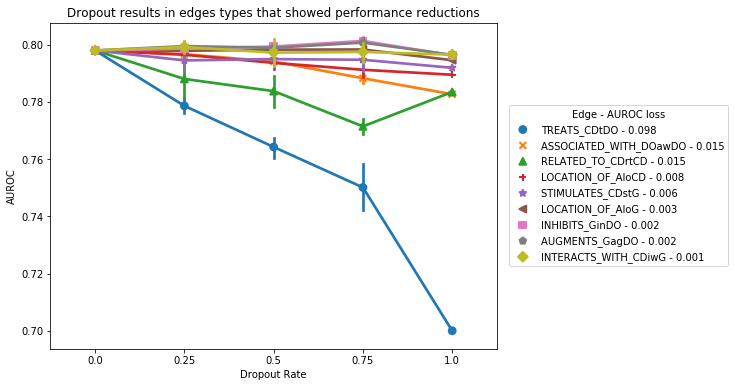

In [16]:
q_edges = res_range.sort_values('auroc', ascending=False)['edge'][:9]
q_res = roc_result.query('edge in @q_edges')

markers = ['o', 'x', '^', '+', '*', '<', 's', 'p', 'D', 'V'][:len(q_edges)]


plt.figure(figsize=(8, 6))
sns.pointplot(x='rate', y='auroc', hue='edge', data=q_res, hue_order=q_edges, markers=markers);

plt.xlabel('Dropout Rate')
plt.ylabel('AUROC')
plt.title('Dropout results in edges types that showed performance reductions')
l = plt.legend(title='Edge - AUROC loss', loc=5, bbox_to_anchor=(1.53, .5))
for edge, t in zip(q_edges, l.get_texts()):
    text = t.get_text()
    t.set_text(text+' - {:.3f}'.format(res_range.set_index('edge').loc[edge, 'auroc']))
plt.savefig(os.path.join(paper_figs, '4A.svg'), bbox_inches='tight', pad_inches=0.1)

In [17]:
q_edges.values

array(['TREATS_CDtDO', 'ASSOCIATED_WITH_DOawDO', 'RELATED_TO_CDrtCD',
       'LOCATION_OF_AloCD', 'STIMULATES_CDstG', 'LOCATION_OF_AloG',
       'INHIBITS_GinDO', 'AUGMENTS_GagDO', 'INTERACTS_WITH_CDiwG'],
      dtype=object)

/opt/mmayers/software/anaconda3/envs/integrate/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


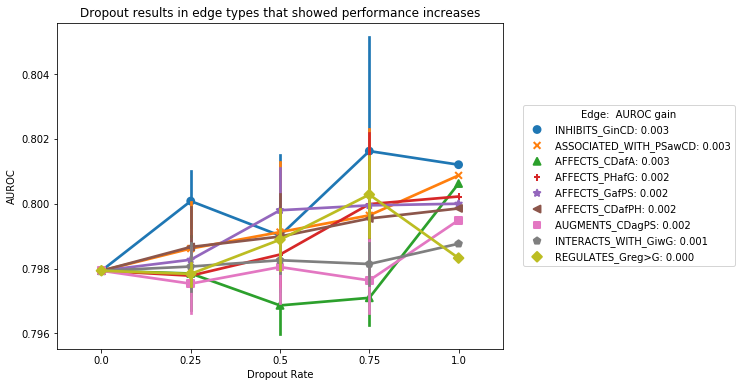

In [18]:
q_edges1 = res_range.sort_values('auroc', ascending=True)['edge'][:9]
q_res = roc_result.query('edge in @q_edges1')

markers = ['o', 'x', '^', '+', '*', '<', 's', 'p', 'D', 'V'][:len(q_edges)]


plt.figure(figsize=(8, 6))
sns.pointplot(x='rate', y='auroc', hue='edge', data=q_res, hue_order=q_edges1, markers=markers);

plt.xlabel('Dropout Rate')
plt.ylabel('AUROC')
plt.title('Dropout results in edge types that showed performance increases')
l = plt.legend(title='Edge:  AUROC gain', loc=5, bbox_to_anchor=(1.53, .5))
for edge, t in zip(q_edges1, l.get_texts()):
    text = t.get_text()
    t.set_text(text+': {:.3f}'.format(-1*res_range.set_index('edge').loc[edge, 'auroc']))

# AUPRC Graphs

/opt/mmayers/software/anaconda3/envs/integrate/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


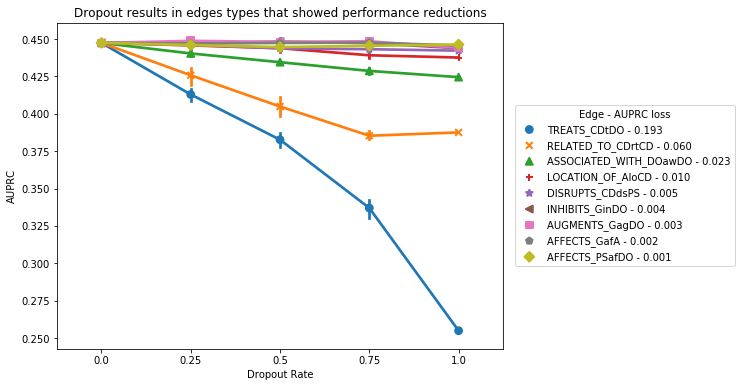

In [19]:
q_edges2 = res_range.sort_values('auprc', ascending=False)['edge'][:9]
q_res = roc_result.query('edge in @q_edges2')

markers = ['o', 'x', '^', '+', '*', '<', 's', 'p', 'D', 'V'][:len(q_edges2)]

plt.figure(figsize=(8, 6))
sns.pointplot(x='rate', y='auprc', hue='edge', data=q_res, hue_order=q_edges2, markers=markers);

plt.xlabel('Dropout Rate')
plt.ylabel('AUPRC')
plt.title('Dropout results in edges types that showed performance reductions')
l = plt.legend(title='Edge - AUPRC loss', loc=5, bbox_to_anchor=(1.53, .5))
for edge, t in zip(q_edges2, l.get_texts()):
    text = t.get_text()
    t.set_text(text+' - {:.3f}'.format(res_range.set_index('edge').loc[edge, 'auprc']))
plt.savefig(os.path.join(other_figs, 'edge_dropout-top_auprc_losers.svg'), bbox_inches='tight', pad_inches=0.1);

In [20]:
q_edges2.values

array(['TREATS_CDtDO', 'RELATED_TO_CDrtCD', 'ASSOCIATED_WITH_DOawDO',
       'LOCATION_OF_AloCD', 'DISRUPTS_CDdsPS', 'INHIBITS_GinDO',
       'AUGMENTS_GagDO', 'AFFECTS_GafA', 'AFFECTS_PSafDO'], dtype=object)

/opt/mmayers/software/anaconda3/envs/integrate/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


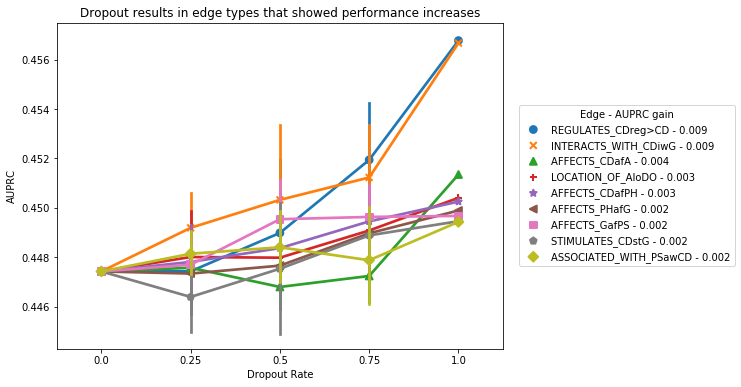

In [21]:
q_edges3 = res_range.sort_values('auprc', ascending=True)['edge'][:9]
q_res = roc_result.query('edge in @q_edges3')

markers = ['o', 'x', '^', '+', '*', '<', 's', 'p', 'D', 'V'][:len(q_edges3)]

plt.figure(figsize=(8, 6))
sns.pointplot(x='rate', y='auprc', hue='edge', data=q_res, hue_order=q_edges3, markers=markers);

plt.xlabel('Dropout Rate')
plt.ylabel('AUPRC')
plt.title('Dropout results in edge types that showed performance increases')
l = plt.legend(title='Edge - AUPRC gain', loc=5, bbox_to_anchor=(1.53, .5))
for edge, t in zip(q_edges3, l.get_texts()):
    text = t.get_text()
    t.set_text(text+' - {:.3f}'.format(-1*res_range.set_index('edge').loc[edge, 'auprc']))

## Attempt to see if there's any bias to more populated edges

We want to try and ensure that dropping out the most populated edges (or simply removing the most data) isn't the main reason we see a reduction in performance.  So we will weight the AUROC and AUPRC changes by number of edges (or log number of edges) to see if these still have the greatest impact.

In [22]:
edges = pd.read_csv('../../data/time_networks-6_metanode/1985/alpha_0.1/10x_pos-neg' +
                          '/0_year_diff/recall-scoring/2_pmids/dwpc_w_0.6/edges_neo4j.csv')
edges.head(2)

,:START_ID,:END_ID,:TYPE,pmids:STRING,n_pmids:INT,pub_years,first_pub
0,D008239,D022781,AFFECTS_CDafA,"http://www.ncbi.nlm.nih.gov/pubmed/496661,2110...",3,"[1979, 2010, 1984]",1979
1,C1610033,D005347,AFFECTS_CDafA,"http://www.ncbi.nlm.nih.gov/pubmed/15184081,24...",5,"[2004, 1985, 2007, 2011, 2007]",1985


In [23]:
edge_counts = edges[':TYPE'].value_counts().rename('count')
edge_counts.head(2)

LOCATION_OF_AloCD    125333
LOCATION_OF_AloDO     77637
Name: count, dtype: int64

In [24]:
edge_counts = edge_counts.to_frame()
edge_counts['log_count'] = np.log(edge_counts['count'])
edge_counts = edge_counts.reset_index().rename(columns={'index': 'edge'})

In [25]:
edge_counts.head(2)

,edge,count,log_count
0,LOCATION_OF_AloCD,125333,11.738729
1,LOCATION_OF_AloDO,77637,11.259799


In [26]:
res_range = pd.merge(res_range, edge_counts, on=['edge'], how='left')
res_range.head(2)

,edge,rate,auprc,auroc,count,log_count
0,TREATS_CDtDO,-1.0,0.192534,0.097925,43120,10.671742
1,ASSOCIATED_WITH_DOawDO,-1.0,0.022895,0.015295,55547,10.924985


In [27]:
res_range['norm_auprc'] = res_range['auprc'] / res_range['count']
res_range['norm_auroc'] = res_range['auroc'] / res_range['count']

res_range['log_norm_auprc'] = res_range['auprc'] / res_range['log_count']
res_range['log_norm_auroc'] = res_range['auroc'] / res_range['log_count']

In [28]:
res_range.head(3)

,edge,rate,auprc,auroc,count,log_count,norm_auprc,norm_auroc,log_norm_auprc,log_norm_auroc
0,TREATS_CDtDO,-1.0,0.192534,0.097925,43120,10.671742,4.465071e-06,2.270992e-06,0.018041,0.009176
1,ASSOCIATED_WITH_DOawDO,-1.0,0.022895,0.015295,55547,10.924985,4.121790e-07,2.753590e-07,0.002096,0.001400
2,RELATED_TO_CDrtCD,-1.0,0.059864,0.014508,24404,10.102502,2.453028e-06,5.944981e-07,0.005926,0.001436


In [29]:
top_auroc = res_range.sort_values('auroc', ascending=False)['edge'].head(10)
top_auprc = res_range.sort_values('auprc', ascending=False)['edge'].head(10)

top_log_norm_auroc = res_range.sort_values('log_norm_auroc', ascending=False)['edge'].head(10)
top_log_norm_auprc = res_range.sort_values('log_norm_auprc', ascending=False)['edge'].head(10)

top_norm_auroc = res_range.sort_values('norm_auroc', ascending=False)['edge'].head(10)
top_norm_auprc = res_range.sort_values('norm_auprc', ascending=False)['edge'].head(10)

In [30]:
normed_data = pd.melt(res_range, id_vars=['edge'], value_vars=['auroc', 'auprc', 'norm_auroc', 'norm_auprc',
                                                                'log_norm_auroc', 'log_norm_auprc'])

normed_data = normed_data.rename(columns={'variable': 'Metric'})
normed_data.head(2)

,edge,Metric,value
0,TREATS_CDtDO,auroc,0.097925
1,ASSOCIATED_WITH_DOawDO,auroc,0.015295


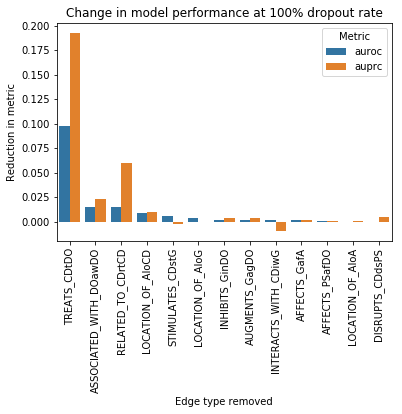

In [31]:
top_auroc_auprc = set(top_auroc).union(set(top_auprc))
data = normed_data.query('edge in @top_auroc_auprc and Metric in {}'.format(['auroc', 'auprc']))

sns.barplot(x='edge', y='value', data=data, hue='Metric')
plt.title('Change in model performance at 100% dropout rate')
plt.xlabel('Edge type removed')
plt.ylabel('Reduction in metric')

plt.xticks(rotation=90);

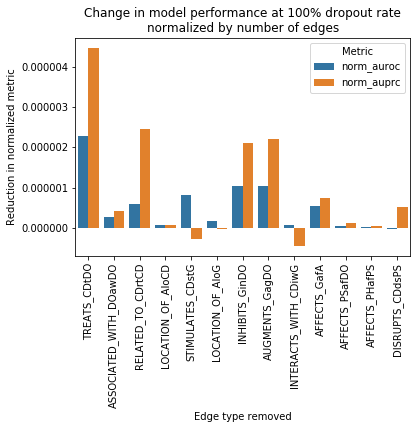

In [32]:
top_auroc_auprc = set(top_norm_auroc).union(set(top_norm_auprc))
data = normed_data.query('edge in @top_auroc_auprc and Metric in {}'.format(['norm_auroc', 'norm_auprc']))

sns.barplot(x='edge', y='value', data=data, hue='Metric')
plt.title('Change in model performance at 100% dropout rate\nnormalized by number of edges')
plt.xlabel('Edge type removed')
plt.ylabel('Reduction in normalized metric')

plt.xticks(rotation=90);

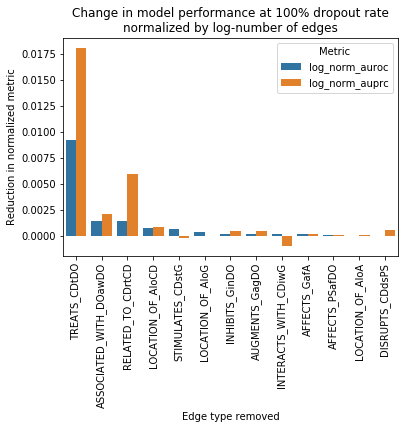

In [33]:
top_auroc_auprc = set(top_log_norm_auroc).union(set(top_log_norm_auprc))
data = normed_data.query('edge in @top_auroc_auprc and Metric in {}'.format(['log_norm_auroc', 'log_norm_auprc']))

sns.barplot(x='edge', y='value', data=data, hue='Metric')
plt.title('Change in model performance at 100% dropout rate\nnormalized by log-number of edges')
plt.xlabel('Edge type removed')
plt.ylabel('Reduction in normalized metric')

plt.xticks(rotation=90);